# Project Benson

## Aim

- High Gala Participation Rate

## How

- Identifying High Traffic Volumes at Subway Entrances/Exits
 - By Day of Week
 - By Hour of Day



- Identifying Target Audience (those more likely to be interested)
 - Identifying Stations with High Volumes of Non-Tourist Traffic (locals)
     - By comparing station's weekend vs weekday traffic

 - [Demographic & Geographic Profiles](https://datausa.io/profile/geo/new-york-ny)
     - Assume areas with more females more interested?
     - Assume areas with higher income more likely to donate?
     - Assume areas with younger demographics more interested?
     - Assume areas with higher education level more interested?
     - Assume areas with high employment in tech industry more interested?
  

## Importing Data for January - June 2019

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

In [ ]:
# 2017 Turnstile data from "https://data.ny.gov/Transportation/Turnstile-Usage-Data-2017/v5y5-mwpb"
# Replace the path below with your own
path = "/Users/kc/OneDrive/Projects/projectbenson/data/data_2017.csv"

df = pd.read_csv(path, sep=',')

In [ ]:
# Remove whitespace from column names
df.columns = df.columns.str.strip()

# Drop irrelevant columns
df.drop(columns=["Line Name", "Division", "Description"], axis=1, inplace=True)

In [ ]:
# Concatenate Date & Time into DateTime column DT
df["DT"] = df[['Date', 'Time']].apply(lambda x: ' '.join(x), axis=1)

# Convert DT into DateTime format
df["DT"] = pd.to_datetime(df["DT"], infer_datetime_format=True)

# Concatenate C/A, Unit & SCP into 1 Unique Identifier Column
df["ID"] = df[["C/A", "Unit", "SCP"]].apply(lambda x: ' '.join(x), axis=1)

In [ ]:
# Rearrange Columns
df = df[["ID", "DT", "Station", "Entries", "Exits"]]

# Drop rows before and after 2017
#df = df.loc[df["DT"].dt.year == 2017]
#df = df.loc[df["DT"].dt.month < 6]

In [ ]:
# Sort DT in descending order
df.sort_values(by=['ID', 'DT'], ascending=[True, False], inplace=True)

# Apply pd.Series.diff() on ["Entries"] and ["Exits"] within each ["ID"] group to obtain value of incremental change
df['Entry_Diff'] = df.groupby(['ID'])['Entries'].apply(lambda x: abs(x.diff()))
df['Exit_Diff'] = df.groupby(['ID'])['Exits'].apply(lambda x: abs(x.diff()))

# Sum values of incremental change for ["Entries"] and ["Exits"] for overall Traffic within time interval
df['Traffic'] = df["Entry_Diff"] + df["Exit_Diff"]

# test
# len(df.loc[df["ID"] == "A002 R051 02-00-00"])
# len(df.loc[df["ID"] == "A002 R051 02-00-01"])
# df.iloc[820:830]
# df.iloc[1640:1650]

In [ ]:
# Remove outliers

f1 = df["Entry_Diff"].quantile(0.99)
df = df[df["Entry_Diff"] < f1]

f2 = df["Exit_Diff"].quantile(0.99)
df = df[df["Exit_Diff"] < f2]

f3 = df["Traffic"].quantile(0.99)
df = df[df["Traffic"] < f3]


In [2]:
# Pickle df so that above won't be necessary on each run
# with open('df.pickle', 'wb') as to_write:
#     pickle.dump(df, to_write)
    
# Open df.pickle & assign to df
with open('df.pickle','rb') as read_file:
    df = pickle.load(read_file)

df.head()

,ID,DT,Station,Entries,Exits,Entry_Diff,Exit_Diff,Traffic
1,A002 R051 02-00-00,2017-12-22 19:00:00,59 ST,6455505,2184926,282.0,51.0,333.0
2,A002 R051 02-00-00,2017-12-22 15:00:00,59 ST,6454819,2184867,686.0,59.0,745.0
3,A002 R051 02-00-00,2017-12-22 11:00:00,59 ST,6454437,2184773,382.0,94.0,476.0
4,A002 R051 02-00-00,2017-12-22 07:00:00,59 ST,6454285,2184501,152.0,272.0,424.0
5,A002 R051 02-00-00,2017-12-22 03:00:00,59 ST,6454273,2184470,12.0,31.0,43.0


In [3]:
# Top Station by Day
daily_sum_station = df.groupby([df["DT"].dt.date, "Station"])["Traffic"].sum().sort_values(ascending=False)
daily_sum_station.head(20)

DT          Station       
2017-07-28  34 ST-PENN STA    249843.0
2017-10-20  34 ST-PENN STA    248981.0
2017-12-21  34 ST-PENN STA    248519.0
2017-04-26  34 ST-PENN STA    247727.0
2017-11-03  34 ST-PENN STA    246450.0
2017-10-06  34 ST-PENN STA    246138.0
2017-10-27  34 ST-PENN STA    244908.0
2017-08-16  34 ST-PENN STA    244728.0
2017-04-05  34 ST-PENN STA    244667.0
2017-11-01  34 ST-PENN STA    243411.0
2017-05-19  34 ST-PENN STA    243126.0
2017-11-02  34 ST-PENN STA    242465.0
2017-12-20  34 ST-PENN STA    242087.0
2017-12-15  34 ST-PENN STA    241994.0
2017-08-01  34 ST-PENN STA    241519.0
2017-06-16  34 ST-PENN STA    240349.0
2017-10-13  34 ST-PENN STA    239887.0
2017-04-27  34 ST-PENN STA    239496.0
2017-08-15  34 ST-PENN STA    239328.0
2017-09-29  34 ST-PENN STA    238410.0
Name: Traffic, dtype: float64

In [42]:
# Top Station by Month
monthly_sum_station = df.groupby(["Station", df["DT"].dt.month])["Traffic"].sum().sort_values(ascending=False)

# Top 5 Stations & Their Busiest Months
df2 = monthly_sum_station.reset_index()
idx = df2.groupby(["Station"])["Traffic"].transform(max) == df2["Traffic"]
df2[idx].head(10)

### Kelsey pls plot
### This one for explaining October as busiest month & if deployment to these stations required,
### the months mentioned here will be the busiest in the year

,Station,DT,Traffic
0,34 ST-PENN STA,10,6345268.0
9,23 ST,5,4534258.0
11,FULTON ST,10,4374033.0
21,GRD CNTRL-42 ST,8,3997521.0
24,TIMES SQ-42 ST,10,3927521.0
26,42 ST-PORT AUTH,8,3852770.0
28,34 ST-HERALD SQ,8,3821568.0
42,86 ST,10,3572016.0
50,125 ST,10,3434653.0
60,CANAL ST,10,3323350.0


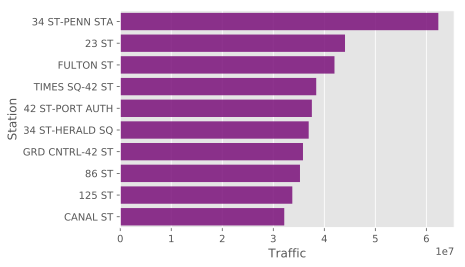

In [5]:
# Overall Top Monthly Station across all Stations
yearly_sum_station = df.groupby(["Station"])["Traffic"].sum().sort_values(ascending=False)

plt.style.use('ggplot')
ax = sns.barplot(y=yearly_sum_station.head(10).index, x=yearly_sum_station.head(10), color='darkmagenta', alpha=0.85)

### Kelsey pls include value label, i.e., 62 mil etc

In [52]:
# Busiest Hour Interval by Station
hourly_sum_station = df.groupby([df["DT"].dt.hour, "Station"])["Traffic"].sum().sort_values(ascending=False)

# Busiest Hour Interval Across All Stations
hourly_sum = df.groupby([df["DT"].dt.hour])["Traffic"].sum().sort_values(ascending=False)
hourly_sum.head()

### Kelsey pls plot

DT
16    299781232.0
8     278030341.0
12    271254526.0
20    159923041.0
4     157014396.0
Name: Traffic, dtype: float64

In [60]:
# Busiest Day by Station
dow_sum_station = df.groupby([df["DT"].dt.dayofweek, "Station"])["Traffic"].sum().sort_values(ascending=False)
dow_sum_station.head(20)

DT  Station        
4   34 ST-PENN STA     10162644.0
2   34 ST-PENN STA     10075228.0
3   34 ST-PENN STA      9962784.0
1   34 ST-PENN STA      9573242.0
0   34 ST-PENN STA      9434388.0
2   23 ST               7564958.0
3   23 ST               7476714.0
    FULTON ST           7473796.0
2   FULTON ST           7464335.0
4   FULTON ST           7350434.0
1   23 ST               7300516.0
    FULTON ST           7241644.0
4   23 ST               7106981.0
5   34 ST-PENN STA      7104829.0
0   23 ST               6950218.0
    FULTON ST           6878909.0
6   34 ST-PENN STA      6036430.0
2   TIMES SQ-42 ST      5936427.0
3   TIMES SQ-42 ST      5932217.0
4   42 ST-PORT AUTH     5869061.0
Name: Traffic, dtype: float64

In [9]:
# Busiest Day Across Stations
# 0 is Monday
dow_sum_all = df.groupby([df["DT"].dt.dayofweek])["Traffic"].sum().sort_values(ascending=False)
dow_sum_all.head(20)

### Kelsey pls plot

DT
2    394460034.0
3    390675845.0
4    385017309.0
1    379881284.0
0    366473768.0
5    254737907.0
6    207678698.0
Name: Traffic, dtype: float64